# Classify the tiles using pretrained tile2vec
In this notebook we are going to measure the performance of classifier on EuroSATallbands dataset.

We will use model weights that are in the `/storage/tile2vec/models/`. Firstly we need to load the weights and create the embeddings of the tiles using our pretrained model.

## Load the model

Firstly we need to load the pretrained model. We use a simple function that loads the checkpoints.

In [1]:
import os
import torch
from pathlib import Path
import sys
sys.path.append("..")

from src.tilenet import make_tilenet


os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda = torch.cuda.is_available()

def load_model(model_filepath, bands = 13, z_dim = 512):
    
    model_dir = Path('/storage/tile2vec/models/limited_bands_models')
    model_fn = model_dir / model_filepath # specify which model weights are to be loaded
    
    bands = bands # number of bands in the input data - should matche the model
    z_dim = z_dim # output dimension of the last layer of the encoder - should match the model


    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    cuda = torch.cuda.is_available()


    tilenet = make_tilenet(in_channels=bands, z_dim=z_dim) 
    if cuda: 
        tilenet.cuda()
        
    print("Model filepath: ", model_fn)

    checkpoint = torch.load(model_fn)
    tilenet.load_state_dict(checkpoint)
    tilenet.eval()
    print("Model succesfully loaded")
    return tilenet

In [2]:
# tilenet = load_model(Path('Tile2Vec_color_infrated.ckpt'), bands=3)
# tilenet = load_model(Path('Tile2Vec_agriculture.ckpt'), bands=3)
# tilenet = load_model(Path('Tile2Vec_vegetation.ckpt'), bands=2)
tilenet = load_model(Path('Tile2Vec_moisture.ckpt'), bands=2)

Model filepath:  /storage/tile2vec/models/limited_bands_models/Tile2Vec_moisture.ckpt
Model succesfully loaded


## load the bare files and organize them into a dataframe

We need to load the files to perform evaluation. To evaluate performance of our trained unsupervised model, we need to perform a simple inference (forward pass) on the tiles and then create a classfier. Here we will use random forests and logistic regression. 

The classifier models will be trained using the embeddings from joined test and validation dataset. Because our dataset is quite well-balanced, our metric is set to be the accuracy measured using the 5-fold crossvalidation.

In [3]:
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from pathlib import Path
from src.data_utils import clip_and_scale_image

In [4]:
val_df = pd.read_csv("/storage/EuroSATallBands/validation.csv")
n_tiles = len(val_df)
tiles_path = Path("/storage/tile2vec/npy/val")

X_bare_val = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_val = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_val[index] = clip_and_scale_image(tile, img_type="landsat").flatten()
    X_bare_val[index] = tile.flatten()
    
y_val = val_df["Label"]

test_df = pd.read_csv("/storage/EuroSATallBands/test.csv")
n_tiles = len(test_df)
tiles_path = Path("/storage/tile2vec/npy/test")

X_bare_test = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_test = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_test[index] = clip_and_scale_image(tile, img_type="landsat").flatten()
    X_bare_test[index] = tile.flatten()
    
y_test = test_df["Label"]


train_df = pd.read_csv("/storage/EuroSATallBands/train.csv")
n_tiles = len(train_df)
tiles_path = Path("/storage/tile2vec/npy/train")

X_bare_train = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_train = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_train[index] =  clip_and_scale_image(tile, img_type="sentinel").flatten()

    X_bare_train[index] = tile.flatten()
    
y_train = train_df["Label"]

  3%|▎         | 155/5519 [00:00<00:03, 1542.48it/s]

100%|██████████| 19317/19317 [00:10<00:00, 1885.87it/s]


In [5]:
y_train = train_df["Label"]
y_validation = val_df["Label"]
y_test = test_df["Label"]

In [6]:
X_norm_valtest = np.concatenate((X_norm_val, X_norm_test), axis=0)
y_valtest = np.concatenate((y_validation, y_test), axis=0)

We also want to compare our model with different methods of dimentionality reduction. Therefore we create variables to evaluate performance of different methods. In the code above we create 6 matrices, two for each part of our data. Each matrix contains observations from sets. For instance, X_*_train contains images as rows, which are flattened to a row-vector. Each collum contains information about pixel on a specific position in the image.

## Embeddings
Below there is a function that creates embeddings from the provided path and the model.

In [7]:

def create_embeddings_tile2vec(tilenet, 
                               df_filepath: str | Path, 
                               tiles_path: str | Path, 
                               img_type: str = "sentinel", 
                               bands: int = 13, 
                               z_dim: int = 512):
    """
    function creates matrix X and y containing embeddings and labels, loads the tiles from directory `tiles_path`
    """
    df_filepath = Path(df_filepath)
    tiles_path = Path(tiles_path)
    df = pd.read_csv(df_filepath)
    n_tiles = len(df)    
    
    X = np.zeros((n_tiles, z_dim))
    
    t0 = time()
    # this solution to iterate over examples is very suboptimal, one should use torch dataset
    for index in tqdm(range(n_tiles)):
        # read the tile from provided filepath
        
        tile = np.load(tiles_path / f"{index}.npy")  
        tile = clip_and_scale_image(tile, img_type=img_type)[:, :bands,:, :]
        tile = torch.from_numpy(tile).float()
        tile = (tile)
        if cuda: 
            tile = tile.cuda()
        z = tilenet.encode(tile)
        if cuda: 
            z = z.cpu()
        z = z.data.numpy()
        
        X[index,:] = z

    t1 = time()
    print('Embedded {} tiles: {:0.3f}s'.format(n_tiles, t1-t0))
    
    y = df['Label'].values
    
    return X, y

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

rf = RandomForestClassifier()

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def compare_results(X, y, model, folds=5, model_name=""):
    if model_name == "":
        model_name = model.__class__.__name__
    
    # Prepare for cross-validation
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    
    # Initialize dictionary to store accuracies for each label
    unique_labels = np.unique(y)
    label_accuracies = {label: [] for label in unique_labels}

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        for label in unique_labels:
            # Select samples with the current label
            mask = (y_test == label)
            y_test_label = y_test[mask]
            y_pred_label = y_pred[mask]
            
            if len(y_test_label) > 0:  # Avoid division by zero if no samples have the current label
                accuracy = accuracy_score(y_test_label, y_pred_label)
                label_accuracies[label].append(accuracy)
    
    # Print averaged accuracies for each label
    for label, accuracies in label_accuracies.items():
        if accuracies:  # Avoid printing if there were no accuracies recorded
            mean_accuracy = np.mean(accuracies)
            std_accuracy = np.std(accuracies)
            print(f"Averaged accuracy for model {model_name} on label {label}: {mean_accuracy*100:.2f}±{std_accuracy*100:.2f}%")

# Evaluation
Finally we perform tests, each section contains code and results of evaluation - the results and model or method type

## Default model scaling
Here we are going to check the performance of model with no band-specfic scaling

Model: Color-Infrared
Model filepath:  /storage/tile2vec/models/limited_bands_models/Tile2Vec_color_infrated.ckpt
Model succesfully loaded


100%|██████████| 5519/5519 [00:19<00:00, 286.13it/s]


Embedded 5519 tiles: 19.291s


100%|██████████| 2759/2759 [00:09<00:00, 281.73it/s]


Embedded 2759 tiles: 9.796s
Averaged accuracy for model RandomForestClassifier on label 0: 47.61±2.35%
Averaged accuracy for model RandomForestClassifier on label 1: 77.94±4.25%
Averaged accuracy for model RandomForestClassifier on label 2: 35.19±2.41%
Averaged accuracy for model RandomForestClassifier on label 3: 11.66±2.59%
Averaged accuracy for model RandomForestClassifier on label 4: 78.99±2.96%
Averaged accuracy for model RandomForestClassifier on label 5: 62.68±3.05%
Averaged accuracy for model RandomForestClassifier on label 6: 26.36±3.37%
Averaged accuracy for model RandomForestClassifier on label 7: 53.02±1.73%
Averaged accuracy for model RandomForestClassifier on label 8: 32.16±3.49%
Averaged accuracy for model RandomForestClassifier on label 9: 57.46±5.22%
Averaged accuracy for model LogisticRegression on label 0: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 1: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 2: 0.00±0.00%
Averaged acc

100%|██████████| 5519/5519 [00:17<00:00, 308.10it/s]


Embedded 5519 tiles: 17.916s


100%|██████████| 2759/2759 [00:10<00:00, 256.05it/s]


Embedded 2759 tiles: 10.778s
Averaged accuracy for model RandomForestClassifier on label 0: 48.31±3.36%
Averaged accuracy for model RandomForestClassifier on label 1: 80.88±3.59%
Averaged accuracy for model RandomForestClassifier on label 2: 36.15±1.04%
Averaged accuracy for model RandomForestClassifier on label 3: 14.35±3.04%
Averaged accuracy for model RandomForestClassifier on label 4: 86.29±2.88%
Averaged accuracy for model RandomForestClassifier on label 5: 63.97±5.05%
Averaged accuracy for model RandomForestClassifier on label 6: 29.65±4.39%
Averaged accuracy for model RandomForestClassifier on label 7: 53.57±1.58%
Averaged accuracy for model RandomForestClassifier on label 8: 31.94±1.39%
Averaged accuracy for model RandomForestClassifier on label 9: 64.10±6.37%
Averaged accuracy for model LogisticRegression on label 0: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 1: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 2: 0.00±0.00%
Averaged ac

100%|██████████| 5519/5519 [00:17<00:00, 308.74it/s]


Embedded 5519 tiles: 17.879s


100%|██████████| 2759/2759 [00:08<00:00, 307.83it/s]


Embedded 2759 tiles: 8.966s
Averaged accuracy for model RandomForestClassifier on label 0: 44.04±3.92%
Averaged accuracy for model RandomForestClassifier on label 1: 79.21±4.26%
Averaged accuracy for model RandomForestClassifier on label 2: 32.77±3.22%
Averaged accuracy for model RandomForestClassifier on label 3: 16.30±3.08%
Averaged accuracy for model RandomForestClassifier on label 4: 84.26±2.06%
Averaged accuracy for model RandomForestClassifier on label 5: 53.66±3.74%
Averaged accuracy for model RandomForestClassifier on label 6: 28.46±3.13%
Averaged accuracy for model RandomForestClassifier on label 7: 45.92±3.66%
Averaged accuracy for model RandomForestClassifier on label 8: 28.40±1.54%
Averaged accuracy for model RandomForestClassifier on label 9: 58.91±4.43%
Averaged accuracy for model LogisticRegression on label 0: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 1: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 2: 0.00±0.00%
Averaged acc

100%|██████████| 5519/5519 [00:18<00:00, 291.91it/s]


Embedded 5519 tiles: 18.910s


100%|██████████| 2759/2759 [00:08<00:00, 307.98it/s]


Embedded 2759 tiles: 8.961s
Averaged accuracy for model RandomForestClassifier on label 0: 44.77±5.18%
Averaged accuracy for model RandomForestClassifier on label 1: 77.83±3.45%
Averaged accuracy for model RandomForestClassifier on label 2: 33.79±3.87%
Averaged accuracy for model RandomForestClassifier on label 3: 10.45±1.41%
Averaged accuracy for model RandomForestClassifier on label 4: 83.83±1.83%
Averaged accuracy for model RandomForestClassifier on label 5: 58.30±4.22%
Averaged accuracy for model RandomForestClassifier on label 6: 29.55±6.03%
Averaged accuracy for model RandomForestClassifier on label 7: 52.29±2.72%
Averaged accuracy for model RandomForestClassifier on label 8: 26.93±3.09%
Averaged accuracy for model RandomForestClassifier on label 9: 55.67±6.16%
Averaged accuracy for model LogisticRegression on label 0: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 1: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 2: 0.00±0.00%
Averaged acc

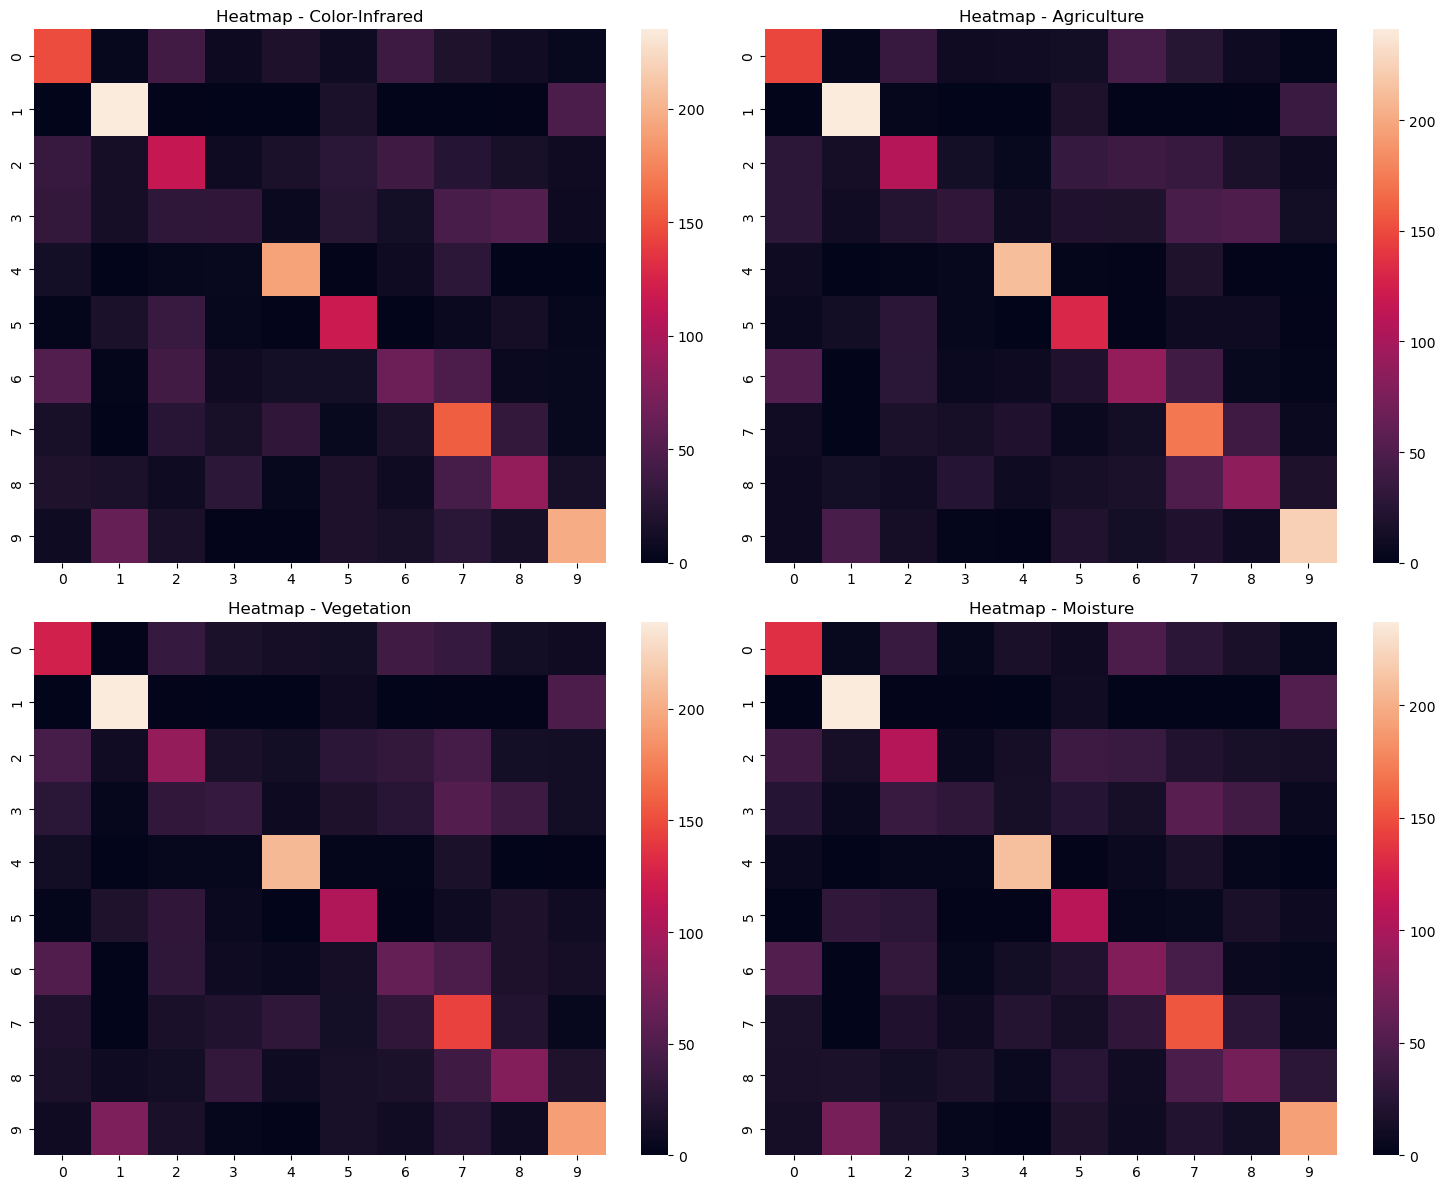

In [20]:
models = {
    # 'no_clipping_name': ('Tile2Vec_model_file.ckpt', bands_number)
    'Color-Infrared': ('Tile2Vec_color_infrated.ckpt', 3),
    'Agriculture': ('Tile2Vec_agriculture.ckpt', 3),
    'Vegetation': ('Tile2Vec_vegetation.ckpt', 2),
    'Moisture': ('Tile2Vec_moisture.ckpt', 2)
}

#comparing models
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
for ax, (name, (model_file, bands)) in zip(axs.flatten(), models.items()):
    print("-"*50)
    print(f"Model: {name}")
    print("-"*50)
    no_clipping = load_model(model_file, bands=bands)

    X_validation, y_validation = create_embeddings_tile2vec(no_clipping, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val', "landsat", bands=bands)
    X_test, y_test = create_embeddings_tile2vec(no_clipping, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test', "landsat", bands=bands)

    X = np.concatenate((X_validation, X_test), axis=0)  
    y = np.concatenate((y_validation, y_test), axis=0)

    compare_results(X, y, RandomForestClassifier(), folds=5)
    compare_results(X, y, LogisticRegression(), folds=5)

    rf = RandomForestClassifier().fit(X_validation, y_validation)
    y_pred = rf.predict(X_test)
    sns.heatmap(confusion_matrix(y_test, y_pred), ax=ax)
    ax.set_title(f"Heatmap - {name}")

plt.tight_layout()
plt.show()

## Custom outlier clipping
Here we evaluate performance of model with band normalization based on IQR on train set

--------------------------------------------------
Model: Color-Infrared
--------------------------------------------------
Model filepath:  /storage/tile2vec/models/limited_bands_models/Tile2Vec_color_infrated.ckpt
Model succesfully loaded


100%|██████████| 5519/5519 [00:19<00:00, 285.76it/s]


Embedded 5519 tiles: 19.316s


100%|██████████| 2759/2759 [00:09<00:00, 296.65it/s]


Embedded 2759 tiles: 9.303s
Averaged accuracy for model RandomForestClassifier on label 0: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 1: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 2: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 3: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 4: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 5: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 6: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 7: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 8: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 9: 100.00±0.00%
Averaged accuracy for model LogisticRegression on label 0: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 1: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 2: 0.00±0.00%
Averaged accuracy fo

100%|██████████| 5519/5519 [00:18<00:00, 295.92it/s]


Embedded 5519 tiles: 18.652s


100%|██████████| 2759/2759 [00:09<00:00, 294.89it/s]


Embedded 2759 tiles: 9.358s
Averaged accuracy for model RandomForestClassifier on label 0: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 1: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 2: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 3: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 4: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 5: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 6: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 7: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 8: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 9: 100.00±0.00%
Averaged accuracy for model LogisticRegression on label 0: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 1: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 2: 0.00±0.00%
Averaged accuracy fo

100%|██████████| 5519/5519 [00:18<00:00, 295.38it/s]


Embedded 5519 tiles: 18.687s


100%|██████████| 2759/2759 [00:09<00:00, 296.46it/s]


Embedded 2759 tiles: 9.309s
Averaged accuracy for model RandomForestClassifier on label 0: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 1: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 2: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 3: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 4: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 5: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 6: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 7: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 8: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 9: 100.00±0.00%
Averaged accuracy for model LogisticRegression on label 0: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 1: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 2: 0.00±0.00%
Averaged accuracy fo

100%|██████████| 5519/5519 [00:18<00:00, 296.23it/s]


Embedded 5519 tiles: 18.634s


100%|██████████| 2759/2759 [00:09<00:00, 295.48it/s]


Embedded 2759 tiles: 9.340s
Averaged accuracy for model RandomForestClassifier on label 0: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 1: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 2: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 3: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 4: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 5: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 6: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 7: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 8: 0.00±0.00%
Averaged accuracy for model RandomForestClassifier on label 9: 100.00±0.00%
Averaged accuracy for model LogisticRegression on label 0: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 1: 0.00±0.00%
Averaged accuracy for model LogisticRegression on label 2: 0.00±0.00%
Averaged accuracy fo

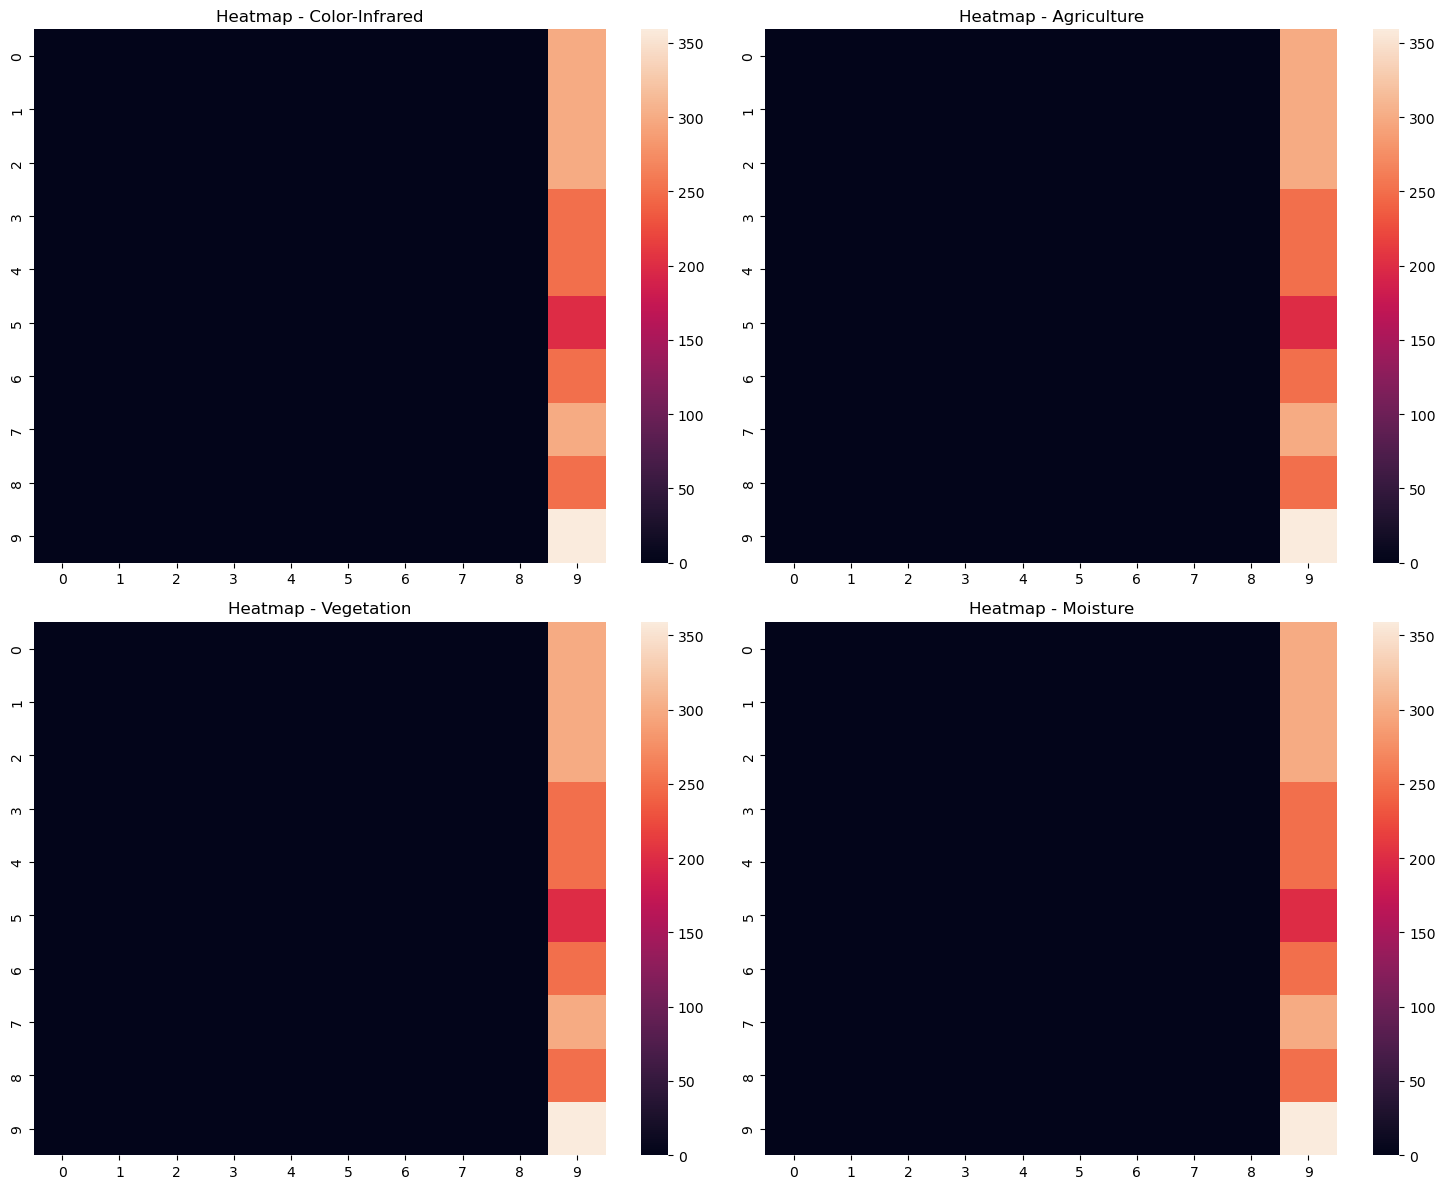

In [24]:
models = {
    # 'no_clipping_name': ('Tile2Vec_model_file.ckpt', bands_number)
    'Color-Infrared': ('Tile2Vec_color_infrated.ckpt', 3),
    'Agriculture': ('Tile2Vec_agriculture.ckpt', 3),
    'Vegetation': ('Tile2Vec_vegetation.ckpt', 2),
    'Moisture': ('Tile2Vec_moisture.ckpt', 2)
}

#comparing models
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
for ax, (name, (model_file, bands)) in zip(axs.flatten(), models.items()):
    print("-"*50)
    print(f"Model: {name}")
    print("-"*50)
    custom_clipping = load_model(model_file, bands=bands)

    X_validation, y_validation = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val', bands=bands)
    X_test, y_test = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test', bands=bands)

    X = np.concatenate((X_validation, X_test), axis=0)  
    y = np.concatenate((y_validation, y_test), axis=0)

    compare_results(X, y, RandomForestClassifier(), folds=5)
    compare_results(X, y, LogisticRegression(), folds=5)

    rf = RandomForestClassifier().fit(X_validation, y_validation)
    y_pred = rf.predict(X_test)
    sns.heatmap(confusion_matrix(y_test, y_pred), ax=ax)
    ax.set_title(f"Heatmap - {name}")

plt.tight_layout()
plt.show()

## PCA 
Instead of some fancy tilenet base encoding we will try to use pca to create embeddings - maybe using the simple dimentionality reduction method we will obtain comparable results

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=512)
pca.fit(X_norm_train)

PCA(n_components=512)

In [23]:
X_pca = pca.transform(X_norm_valtest)

In [24]:
compare_results(X_pca, y_valtest, rf, folds = 5)
compare_results(X_pca, y_valtest, lr, folds = 5)

Averaged accuracy for model RandomForestClassifier: 75.57±0.88%


/home/natalia/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/natalia/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

Averaged accuracy for model LogisticRegression: 69.56±1.06%


/home/natalia/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
import pickle

with open("/storage/tile2vec/models/pca.pkl", "wb") as p:
    pickle.dump(pca, p)

PermissionError: [Errno 13] Permission denied: '/storage/tile2vec/models/pca.pkl'

## FastICA

In [26]:
from sklearn.decomposition import FastICA

fastica = FastICA(n_components=512)

fastica.fit(X_norm_train)

/home/natalia/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


FastICA(n_components=512)

In [27]:
X_fastica = fastica.transform(X_norm_valtest)

compare_results(X_fastica, y_valtest, rf, folds = 5)
compare_results(X_fastica, y_valtest, lr, folds = 5)

Averaged accuracy for model RandomForestClassifier: 76.69±0.78%


/home/natalia/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/natalia/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

Averaged accuracy for model LogisticRegression: 64.42±1.03%


/home/natalia/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:

with open("/storage/tile2vec/models/fastica.pkl", "wb") as p:
    pickle.dump(fastica, p)

## KMeans

KMeans with 10 clusters

In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 10)

kmeans.fit(X_norm_train, y_train)

X_kmeans = kmeans.transform(X_norm_valtest)

In [41]:
with open("/storage/tile2vec/models/kmeans.pkl", "wb") as p:
    pickle.dump(kmeans, p)

In [35]:
compare_results(X_kmeans, y_valtest, rf, folds = 5)
compare_results(X_kmeans, y_valtest, lr, folds = 5)

Averaged accuracy for model RandomForestClassifier: 75.15±0.82%
Averaged accuracy for model LogisticRegression: 75.19±0.68%


## No embeddings

In [42]:
compare_results(X_norm_valtest, y_valtest, rf, folds = 5)
compare_results(X_norm_valtest, y_valtest, lr, folds = 5)

Averaged accuracy for model RandomForestClassifier: 79.71±1.05%
Averaged accuracy for model LogisticRegression: 79.72±1.42%


## Pretrained ResNet18

In [53]:
from src.resnet import ResNet18


os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda = torch.cuda.is_available()


og_tilenet = ResNet18()
if cuda: 
    og_tilenet.cuda()
    

checkpoint = torch.load("models/naip_trained.ckpt")
og_tilenet.load_state_dict(checkpoint)
og_tilenet.eval()

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [57]:
X_validation, y_validation = create_embeddings_tile2vec(og_tilenet, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val', bands=4)
X_test, y_test = create_embeddings_tile2vec(og_tilenet, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test', bands=4)

100%|██████████| 5519/5519 [00:59<00:00, 92.09it/s] 


Embedded 5519 tiles: 59.936s


100%|██████████| 2759/2759 [00:29<00:00, 92.85it/s]

Embedded 2759 tiles: 29.718s


In [58]:

X = np.concatenate((X_validation, X_test), axis=0)
y = np.concatenate((y_validation, y_test), axis=0)

compare_results(X, y, rf, folds = 5)
compare_results(X, y, lr, folds = 5)

Averaged accuracy for model RandomForestClassifier: 45.80±1.50%
Averaged accuracy for model LogisticRegression: 45.12±1.61%


## Tile size 40

In [12]:
custom_clipping = load_model("TileNet_tile_40.ckpt")
X_validation, y_validation = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val', "landsat")
X_test, y_test = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test')

X = np.concatenate((X_validation, X_test), axis=0)
y = np.concatenate((y_validation, y_test), axis=0)

compare_results(X, y, rf, folds = 5)
compare_results(X, y, lr, folds = 5)

/storage/tile2vec/models/TileNet_tile_40.ckpt


100%|██████████| 5519/5519 [00:33<00:00, 162.93it/s]


Embedded 5519 tiles: 33.877s


100%|██████████| 2759/2759 [00:18<00:00, 150.43it/s]


Embedded 2759 tiles: 18.343s
Averaged accuracy for model RandomForestClassifier: 52.34±4.33%
Averaged accuracy for model LogisticRegression: 51.60±4.23%


## tile size 30

In [13]:
custom_clipping = load_model("TileNet_tile_30.ckpt")
X_validation, y_validation = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val', "landsat")
X_test, y_test = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test')

X = np.concatenate((X_validation, X_test), axis=0)
y = np.concatenate((y_validation, y_test), axis=0)

compare_results(X, y, rf, folds = 5)
compare_results(X, y, lr, folds = 5)

/storage/tile2vec/models/TileNet_tile_30.ckpt


100%|██████████| 5519/5519 [00:22<00:00, 248.83it/s]


Embedded 5519 tiles: 22.182s


100%|██████████| 2759/2759 [00:12<00:00, 217.08it/s]


Embedded 2759 tiles: 12.712s
Averaged accuracy for model RandomForestClassifier: 53.66±1.17%
Averaged accuracy for model LogisticRegression: 53.44±1.09%


## tile size 60

In [14]:
custom_clipping = load_model("TileNet_tile_60.ckpt")
X_validation, y_validation = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val', "landsat")
X_test, y_test = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test')

X = np.concatenate((X_validation, X_test), axis=0)
y = np.concatenate((y_validation, y_test), axis=0)

compare_results(X, y, rf, folds = 5)
compare_results(X, y, lr, folds = 5)

/storage/tile2vec/models/TileNet_tile_60.ckpt


100%|██████████| 5519/5519 [00:17<00:00, 308.33it/s]


Embedded 5519 tiles: 17.901s


100%|██████████| 2759/2759 [00:10<00:00, 256.53it/s]


Embedded 2759 tiles: 10.757s
Averaged accuracy for model RandomForestClassifier: 56.73±0.90%
Averaged accuracy for model LogisticRegression: 56.43±0.97%
